In [2]:
%reload_ext autoreload
%autoreload 2


In [7]:
#!/usr/bin/env python
# -*- coding:utf-8 -*-
#
# Created: 03/2022
# Author: Carmelo Mordini <cmordini@phys.ethz.ch>

import cvxpy as cx
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sg

from pytrans import objectives as obj
from pytrans.solver import solver, init_waveform

from models.surface_trap.filter import trap_filter
from pytrans.transform import TrapFilterTransform


n_samples = 256
_t = np.arange(n_samples)
voltage0 = sg.sawtooth(2 * np.pi * 4 * _t / _t.max(), width=0.5)
n_pad = 30
filter_transform = TrapFilterTransform(trap_filter)

waveform0 = init_waveform(n_samples, 1)
waveform_filtered = filter_transform.transform(waveform0, pad_after=n_pad)
print(waveform_filtered.shape)

objectives = []

objectives += [
    obj.VoltageObjective(waveform_filtered[j], v)
    for j, v in enumerate(voltage0)
]

objectives += [
    obj.VoltageObjective(waveform_filtered[n_samples + j], voltage0[-1], weight=1e3)
    for j in range(n_pad)
]


objectives += [
    obj.VoltageObjective(waveform0, -10, constraint_type='>='),
    obj.VoltageObjective(waveform0, 10, constraint_type='<='),
    obj.SlewRateObjective(waveform0, dt=trap_filter.dt, weight=1),
    # obj.SlewRateObjective(waveform0, dt=trap_filter.dt, value=8e6, constraint_type='<=')
]

# trap_filter = None
# step_objectives[0][0].weight *= 10

print("Running solver")
# start_value = np.tile(v_start, (len(step_objectives), 1))
_res = solver(objectives, verbose=False)
print("done")



(286, 1)
Running solver
done


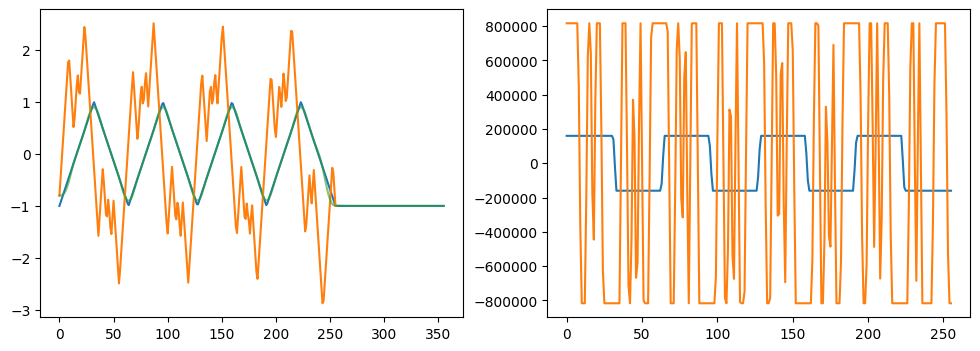

In [8]:
from pytrans.transform.filter import pad_waveform
pad2 = 100


dt = trap_filter.dt

v0 = pad_waveform(voltage0, pad_after=pad2)
wf0 = _res.waveform.value
wf_filt = filter_transform.transform(wf0, pad_after=pad2)

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 4))
ax.plot(v0)
ax.plot(wf0)
ax.plot(wf_filt, alpha=0.6)

dv = np.gradient(voltage0, dt, axis=0)
dw = np.gradient(wf0, dt, axis=0)

ax1.plot(dv)
ax1.plot(dw)

# ax.set_xlim(200, 300)


In [10]:
(wf_filt - v0)[-20:, 0].mean()

-0.0010924328613494017